# Coverage Bias Analysis: Sequencing depth across performance averaged across all 36 isolates

### Maximillian Marin
### mgmarin@g.harvard.edu


### Goal:

In [1]:
import numpy as np
import pandas as pd
import vcf
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

%matplotlib inline

In [2]:
from scipy.stats import spearmanr

In [3]:
from Bio import SeqIO

#### Pandas Viewing Settings

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Set matplotlib text export settings for Adobe Illustrator

In [5]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Parse Assembly and Sequence analysis results Sample Info

In [6]:
Repo_DataDir = "../../Data"

PMP_SM_ResultsSummary_Dir_210108 = Repo_DataDir + "/210108_PMP_SM_50CI_V7_ResultsSummary"


PMP_50CI_AssemblySummary_TSV_PATH = PMP_SM_ResultsSummary_Dir_210108 + "/210108_PMP_50CI_AssemblySummary_V7.tsv"

PMP_42CI_CicularOnly_AssemblySummary_TSV_PATH = PMP_SM_ResultsSummary_Dir_210108 + "/210108_PMP_42CI_CircularOnly_F2Filtered_AssemblySummary_V7.tsv" 

PMP_36CI_CicularOnly_F2Filtered_AtLeast40XIllDepth_AssemblySummary_TSV_PATH = PMP_SM_ResultsSummary_Dir_210108 + "/210108_PMP_36CI_CircularOnly_F2Filtered_AtLeast40XMeanDepthIllumina_AssemblySummary_V7.tsv"       


PMP_50CI_AssemblySummary = pd.read_csv(PMP_50CI_AssemblySummary_TSV_PATH, sep = "\t")

PMP_42CI_CicularOnly_AssemblySummary = pd.read_csv(PMP_42CI_CicularOnly_AssemblySummary_TSV_PATH, sep = "\t")

PMP_36CI_CicularOnly_F2Filtered_AtLeast40XDepth_AssemblySummary = pd.read_csv(PMP_36CI_CicularOnly_F2Filtered_AtLeast40XIllDepth_AssemblySummary_TSV_PATH, sep = "\t")

PMP_36CI_AnalysisSet_AssemblySummary = PMP_36CI_CicularOnly_F2Filtered_AtLeast40XDepth_AssemblySummary


SampleIDs_36CI_SOI = list( PMP_36CI_AnalysisSet_AssemblySummary["SampleID"].values )


print(','.join(SampleIDs_36CI_SOI) )

# Make sample to lineage mapping dict

ID_To_IlluminaAvrgCov_Dict = dict(PMP_50CI_AssemblySummary[['SampleID', 'IlluminaWGSToH37rv_AvrgCov']].values)                     
ID_To_Lineage_Dict = dict(PMP_50CI_AssemblySummary[['SampleID', 'PrimaryLineage_PB']].values)
ID_To_Dataset_Dict = dict(PMP_50CI_AssemblySummary[['SampleID', 'Dataset_Tag']].values)

M0011368_9,M0014888_3,M0016395_7,M0010874_7,01_R1430,02_R0894,02_R1708,02_R1896,M0016737_0,M0017522_5,01_R1134,M0003941_3,02_R1179,N1176,N0072,N0153,N0145,N0155,N0004,N1274,N0054,N1272,N0091,N1202,N1177,RW-TB008,DNA028,DNA075,DNA091,DNA044,DNA020,AZE_02_042,DNA019_Rose,DNA120,DNA188,DNA086


## Define Directories

In [7]:
PB_Vs_Illumina_DataAnalysis_Dir = "../../../210112_PBvsI_VCeval_AnalysisDir_V7_36CI"

CoverageBiasAnalysis_V2_Dir = PB_Vs_Illumina_DataAnalysis_Dir + "/210113_CoverageBiasAnalysis_GC_V2"  


## Parse Coverage Bias raw data table (11 GB of data in TSV)

Read in relative coverage measurements (for Illumina & PacBio) across all bp positions of all 36 genome assemblies

In [8]:
import time

In [9]:
Combined_CovBias_TSV_PATH = f"{CoverageBiasAnalysis_V2_Dir}/210113.CoverageBiasAnalysis.Mtb.36CI.V3.GC.SH.tsv"


start = time.time()
All_Cov_GC_DF = pd.read_csv(Combined_CovBias_TSV_PATH, sep = "\t")

end = time.time()

RunTime_Sec = (end - start)

print("Running Time:", RunTime_Sec)

Running Time: 113.59826970100403


In [10]:
#del listOf_Sample_Cov_GC_DF

In [11]:
#All_Cov_GC_DF.memory_usage(deep=True)

In [12]:
#All_Cov_GC_DF.shape

In [13]:
#All_Cov_GC_DF.head(3)

# Calculate the average relative coverage for all GC% values (across all 36 samples)

In [14]:
listOf_Sample_CovBias_DFs = []

for SampleID in tqdm(SampleIDs_36CI_SOI):
    
    #print(f"Sample: {SampleID}")
    
    sample_CovBias_Dir = f"{CoverageBiasAnalysis_V2_Dir}/{SampleID}"
    sample_CovBias_TSV_PATH = f"{sample_CovBias_Dir}/{SampleID}.Depth.GCcontent.tsv"
    Sample_Cov_GC_DF = pd.read_csv(sample_CovBias_TSV_PATH, sep = "\t")

    i_GC_Bin_Vs_Cov_Bias = Sample_Cov_GC_DF.groupby("GC_100bp").mean()
    i_GC_Bin_Vs_Cov_Bias["GC_100bp"] = i_GC_Bin_Vs_Cov_Bias.index

    i_GC_Bins_Counts = Sample_Cov_GC_DF.groupby("GC_100bp").agg(count=('GC_100bp', 'size'))

    i_GC_Bin_Vs_Cov_Bias = i_GC_Bin_Vs_Cov_Bias.merge(i_GC_Bins_Counts, left_index=True, right_index=True)

    i_GC_Bin_Vs_Cov_Bias["Norm_Counts"] = i_GC_Bin_Vs_Cov_Bias["count"] / i_GC_Bin_Vs_Cov_Bias["count"].sum()

    #i_GC_Bin_Vs_Cov_Bias_F = i_GC_Bin_Vs_Cov_Bias[ i_GC_Bin_Vs_Cov_Bias["count"] >= 1000]
    i_GC_Bin_Vs_Cov_Bias_F = i_GC_Bin_Vs_Cov_Bias
    
    i_GC_Bin_Vs_Cov_Bias_F["SampleID"] = SampleID
    i_GC_Bin_Vs_Cov_Bias_F["Dataset"] = ID_To_Dataset_Dict[SampleID]
    
    listOf_Sample_CovBias_DFs.append(i_GC_Bin_Vs_Cov_Bias_F)
    
    #break


100%|██████████| 36/36 [02:12<00:00,  3.64s/it]


In [15]:
X_CovBiasMeans = pd.concat( listOf_Sample_CovBias_DFs )
X_CovBiasMeans  = X_CovBiasMeans .reset_index(drop=True)

In [16]:
X_CovBiasMeans["Dataset"].value_counts()

Farhat_Peru_2019        815
ChinerOms_2019          747
TB_Portals_15CI_R1      693
Ngabonziza_Lin8_2020     63
Name: Dataset, dtype: int64

In [17]:
X_CovBiasMeans.head(3)

,Illumina_DP,Illumina_DP_PBN,PacBio_DP,PacBio_DP_PBN,RefPos_0based,GC_100bp,count,Norm_Counts,SampleID,Dataset
0,59.0,1.435890,226.0,1.173561,4048552.0,31.0,1,2.273853e-07,M0011368_9,Farhat_Peru_2019
1,58.5,1.423722,224.5,1.165772,4048552.0,32.0,2,4.547707e-07,M0011368_9,Farhat_Peru_2019
2,57.5,1.399385,218.0,1.132019,4048552.0,33.0,2,4.547707e-07,M0011368_9,Farhat_Peru_2019


In [18]:
X_CovBiasMeans_S = X_CovBiasMeans.drop(["RefPos_0based", "Illumina_DP", "PacBio_DP", "Dataset"], axis = 1)

In [19]:
X_CovBiasMeans_S.head()

,Illumina_DP_PBN,PacBio_DP_PBN,GC_100bp,count,Norm_Counts,SampleID
0,1.435890,1.173561,31.0,1,2.273853e-07,M0011368_9
1,1.423722,1.165772,32.0,2,4.547707e-07,M0011368_9
2,1.399385,1.132019,33.0,2,4.547707e-07,M0011368_9
3,1.408849,1.032203,34.0,9,2.046468e-06,M0011368_9
4,1.315044,0.985906,35.0,29,6.594175e-06,M0011368_9


## make DF more "tidy" with pd.melt() function

In [20]:
X_CovBiasMeans_Tidy = pd.melt(X_CovBiasMeans_S,
                              id_vars = [ "GC_100bp", "count", 'Norm_Counts', "SampleID", ], #"Dataset"],
                              value_vars= ["Illumina_DP_PBN", "PacBio_DP_PBN"],
                              var_name = "SequencingTechnology",
                              value_name = "RelativeDepth")

In [21]:
X_CovBiasMeans_Tidy.head()

,GC_100bp,count,Norm_Counts,SampleID,SequencingTechnology,RelativeDepth
0,31.0,1,2.273853e-07,M0011368_9,Illumina_DP_PBN,1.435890
1,32.0,2,4.547707e-07,M0011368_9,Illumina_DP_PBN,1.423722
2,33.0,2,4.547707e-07,M0011368_9,Illumina_DP_PBN,1.399385
3,34.0,9,2.046468e-06,M0011368_9,Illumina_DP_PBN,1.408849
4,35.0,29,6.594175e-06,M0011368_9,Illumina_DP_PBN,1.315044


### Filter Coverage Bias DF by the # of total counts across all genomes

We removed all GC% values for 


In [22]:
X_CovBiasMeans_SumOfCounts = X_CovBiasMeans.groupby("GC_100bp").sum()
GC_ContentValues_WithEnoughCounts = X_CovBiasMeans_SumOfCounts[ X_CovBiasMeans_SumOfCounts["count"] >= 1000].index.values

In [23]:
min(GC_ContentValues_WithEnoughCounts)

35.0

In [24]:
max(GC_ContentValues_WithEnoughCounts)

91.0

In [25]:
X_CovBiasMeans_F = X_CovBiasMeans[ X_CovBiasMeans["GC_100bp"].isin(GC_ContentValues_WithEnoughCounts)]

In [26]:
X_CovBiasMeans_Tidy_F = X_CovBiasMeans_Tidy[ X_CovBiasMeans_Tidy["GC_100bp"].isin(GC_ContentValues_WithEnoughCounts)]

In [27]:
X_CovBiasMeans_Tidy_F.head(25)

,GC_100bp,count,Norm_Counts,SampleID,SequencingTechnology,RelativeDepth
4,35.0,29,0.000007,M0011368_9,Illumina_DP_PBN,1.315044
5,36.0,76,0.000017,M0011368_9,Illumina_DP_PBN,1.351991
6,37.0,95,0.000022,M0011368_9,Illumina_DP_PBN,1.310362
7,38.0,126,0.000029,M0011368_9,Illumina_DP_PBN,1.281562
8,39.0,181,0.000041,M0011368_9,Illumina_DP_PBN,1.280993
9,40.0,323,0.000073,M0011368_9,Illumina_DP_PBN,1.242851
10,41.0,504,0.000115,M0011368_9,Illumina_DP_PBN,1.230908
11,42.0,755,0.000172,M0011368_9,Illumina_DP_PBN,1.254958
12,43.0,982,0.000223,M0011368_9,Illumina_DP_PBN,1.242953
13,44.0,1391,0.000316,M0011368_9,Illumina_DP_PBN,1.240021


In [28]:
X_CovBiasMeans_Tidy_F.tail(25)

,GC_100bp,count,Norm_Counts,SampleID,SequencingTechnology,RelativeDepth
4609,67.0,311103,0.070842,DNA086,PacBio_DP_PBN,0.995741
4610,68.0,290987,0.066262,DNA086,PacBio_DP_PBN,0.991579
4611,69.0,262727,0.059826,DNA086,PacBio_DP_PBN,0.988939
4612,70.0,228669,0.052071,DNA086,PacBio_DP_PBN,0.987271
4613,71.0,191003,0.043494,DNA086,PacBio_DP_PBN,0.985703
4614,72.0,151264,0.034445,DNA086,PacBio_DP_PBN,0.984845
4615,73.0,118870,0.027068,DNA086,PacBio_DP_PBN,0.982489
4616,74.0,90830,0.020683,DNA086,PacBio_DP_PBN,0.980823
4617,75.0,67425,0.015354,DNA086,PacBio_DP_PBN,0.979070
4618,76.0,49596,0.011294,DNA086,PacBio_DP_PBN,0.975172


In [29]:
#i_GC_Bin_Vs_Cov_Bias_F = X[ i_GC_Bin_Vs_Cov_Bias["count"] >= 1000]

In [30]:
#g = sns.relplot(x="GC_100bp", y="RelativeDepth", hue="SequencingTechnology", col="SampleID", col_wrap=3, height=6, aspect=3, 
#            kind="line", data=X_CovBiasMeans_Tidy_F, legend="full"  )

#g.map(plt.axhline, y=1, ls='--', c='black')

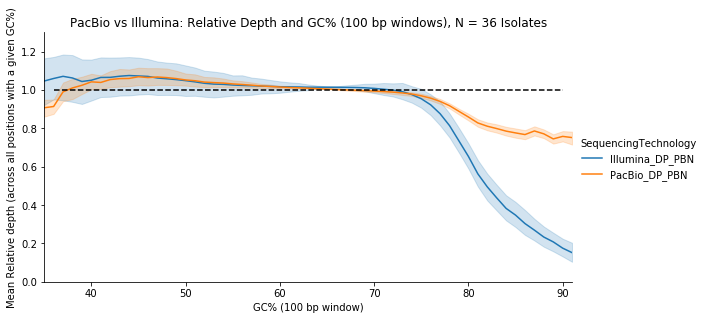

In [31]:

sns.relplot(x="GC_100bp", y="RelativeDepth",
            kind="line", hue = "SequencingTechnology",
            data=X_CovBiasMeans_Tidy_F,
            height=4, # make the plot 5 units high
            aspect=2)

plt.plot([36,90], [1,1], linestyle="--", color="black")

plt.ylim(0, 1.3)
plt.xlim(35, 91)

plt.title("PacBio vs Illumina: Relative Depth and GC% (100 bp windows), N = 36 Isolates")

plt.xlabel("GC% (100 bp window)")
plt.ylabel("Mean Relative depth (across all positions with a given GC%)")


!mkdir ./SeqDepthBias_Plots/

Output_PNG_PATH = "./SeqDepthBias_Plots/RelativeDepth_Vs_GCcontent_36CI_Comparing_Illumina_and_PacBio_V1.png"
Output_PDF_PATH = "./SeqDepthBias_Plots/RelativeDepth_Vs_GCcontent_36CI_Comparing_Illumina_and_PacBio_V1.pdf"

plt.savefig(Output_PNG_PATH, bbox_inches='tight', dpi=100)
plt.savefig(Output_PDF_PATH, bbox_inches='tight', transparent=True)

plt.show()


# What is the mean relative depth of positions with a GC% >= 80%?

In [32]:
X_CovBiasMeans_Tidy_F[ X_CovBiasMeans_Tidy_F["GC_100bp"] >= 80].groupby("SequencingTechnology").mean()

,GC_100bp,count,Norm_Counts,RelativeDepth
SequencingTechnology,,,,
Illumina_DP_PBN,85.5,5194.93287,0.001178,0.351704
PacBio_DP_PBN,85.5,5194.93287,0.001178,0.786498


In [33]:
X_CovBiasMeans_Tidy_F[ X_CovBiasMeans_Tidy_F["GC_100bp"] >= 80].groupby("SequencingTechnology").median()

,GC_100bp,count,Norm_Counts,RelativeDepth
SequencingTechnology,,,,
Illumina_DP_PBN,85.5,3668.5,0.00083,0.336960
PacBio_DP_PBN,85.5,3668.5,0.00083,0.792365


In [34]:
X_CovBiasMeans_Tidy_F.head()

,GC_100bp,count,Norm_Counts,SampleID,SequencingTechnology,RelativeDepth
4,35.0,29,0.000007,M0011368_9,Illumina_DP_PBN,1.315044
5,36.0,76,0.000017,M0011368_9,Illumina_DP_PBN,1.351991
6,37.0,95,0.000022,M0011368_9,Illumina_DP_PBN,1.310362
7,38.0,126,0.000029,M0011368_9,Illumina_DP_PBN,1.281562
8,39.0,181,0.000041,M0011368_9,Illumina_DP_PBN,1.280993


In [35]:
X_CovBiasMeans_Tidy_F.groupby("SequencingTechnology").mean()

,GC_100bp,count,Norm_Counts,RelativeDepth
SequencingTechnology,,,,
Illumina_DP_PBN,63.0,77390.970273,0.017544,0.874853
PacBio_DP_PBN,63.0,77390.970273,0.017544,0.962645


In [36]:
X_CovBiasMeans_Tidy_F[ X_CovBiasMeans_Tidy_F["GC_100bp"] >= 80].groupby("SequencingTechnology").mean()

,GC_100bp,count,Norm_Counts,RelativeDepth
SequencingTechnology,,,,
Illumina_DP_PBN,85.5,5194.93287,0.001178,0.351704
PacBio_DP_PBN,85.5,5194.93287,0.001178,0.786498


# Calculating Proportion of Low Sequencing Depth Regions for both technologies

## Let's try calculating the proportion of the genome with relative coverage below varying thresholds

In [37]:
listOf_RelCov_Threshs = [0, 0.1, 0.25, 0.5]
listOf_RelCov_Threshs = [0.25]

listOf_RelCov_Threshs = [0.25, 0.5]

listOf_RowTuples = []

for i_sampleID in tqdm(SampleIDs_36CI_SOI):

    i_AllBP_Cov_DF = All_Cov_GC_DF[ (All_Cov_GC_DF["SampleID"] == i_sampleID) ]

    i_Num_BP_Total = i_AllBP_Cov_DF.shape[0]

    i_dictOf_RelCov_BelowThresh = { }


    for thresh in listOf_RelCov_Threshs:
        i_dictOf_RelCov_BelowThresh[thresh] = {}
        
        i_AllBP_Cov_DF_BelowThresh_Illumina = i_AllBP_Cov_DF[ (i_AllBP_Cov_DF["Illumina_DP_PBN"] < thresh) ]
        i_Num_BP_BelowThresh_Illumina = i_AllBP_Cov_DF_BelowThresh_Illumina.shape[0]
    
        i_AllBP_Cov_DF_BelowThresh_PB = i_AllBP_Cov_DF[ (i_AllBP_Cov_DF["PacBio_DP_PBN"] < thresh) ]
        i_Num_BP_BelowThresh_PB = i_AllBP_Cov_DF_BelowThresh_PB.shape[0]

        i_proportionBelowThresh_Illumina = (i_Num_BP_BelowThresh_Illumina / i_Num_BP_Total)
        i_proportionBelowThresh_PacBio = (i_Num_BP_BelowThresh_PB / i_Num_BP_Total)
    
        i_dictOf_RelCov_BelowThresh[thresh]["Illumina"] = i_proportionBelowThresh_Illumina
        i_dictOf_RelCov_BelowThresh[thresh]["PacBio"] = i_proportionBelowThresh_PacBio

        i_rowTuple = (i_sampleID, thresh, "PacBio", i_Num_BP_Total, i_proportionBelowThresh_PacBio)
    
        listOf_RowTuples.append( i_rowTuple )

        i_rowTuple = (i_sampleID, thresh, "Illumina", i_Num_BP_Total, i_proportionBelowThresh_Illumina)
    
        listOf_RowTuples.append( i_rowTuple )
        
    #break

100%|██████████| 36/36 [05:54<00:00,  9.83s/it]


In [38]:
RelCov_BelowThresh_DF = pd.DataFrame(listOf_RowTuples)
RelCov_BelowThresh_DF.columns = ["SampleID", "Threshold", "Seq_Platform", "Total_BP", "FracRelCov_BelowThresh"]

In [39]:
RelCov_BelowThresh_DF.tail(4)

,SampleID,Threshold,Seq_Platform,Total_BP,FracRelCov_BelowThresh
140,DNA086,0.25,PacBio,4391492,0.000449
141,DNA086,0.25,Illumina,4391492,0.007783
142,DNA086,0.50,PacBio,4391492,0.000702
143,DNA086,0.50,Illumina,4391492,0.030698


In [40]:
# https://stackoverflow.com/questions/19202093/how-to-select-columns-from-groupby-object-in-pandas
RelCov_BelowThresh_DF_AllSamplesMean = RelCov_BelowThresh_DF.groupby(["Threshold", "Seq_Platform",]).mean().reset_index()

In [41]:
RelCov_BelowThresh_DF_AllSamplesMean

,Threshold,Seq_Platform,Total_BP,FracRelCov_BelowThresh
0,0.25,Illumina,4.411358e+06,0.012110
1,0.25,PacBio,4.411358e+06,0.000058
2,0.50,Illumina,4.411358e+06,0.039652
3,0.50,PacBio,4.411358e+06,0.002743


In [42]:
RelCov_BelowThresh_DF_AllSamplesStd = RelCov_BelowThresh_DF.groupby(["Threshold", "Seq_Platform",]).std().reset_index()

In [43]:
RelCov_BelowThresh_DF_AllSamplesStd

,Threshold,Seq_Platform,Total_BP,FracRelCov_BelowThresh
0,0.25,Illumina,16111.314908,0.011243
1,0.25,PacBio,16111.314908,0.000139
2,0.50,Illumina,16111.314908,0.039929
3,0.50,PacBio,16111.314908,0.003382


# Outputing tables of data used to make figures and cite statistics

In [44]:
X_CovBiasMeans_Tidy_F.shape

(4104, 6)

In [45]:
X_CovBiasMeans_Tidy_F.head()

,GC_100bp,count,Norm_Counts,SampleID,SequencingTechnology,RelativeDepth
4,35.0,29,0.000007,M0011368_9,Illumina_DP_PBN,1.315044
5,36.0,76,0.000017,M0011368_9,Illumina_DP_PBN,1.351991
6,37.0,95,0.000022,M0011368_9,Illumina_DP_PBN,1.310362
7,38.0,126,0.000029,M0011368_9,Illumina_DP_PBN,1.281562
8,39.0,181,0.000041,M0011368_9,Illumina_DP_PBN,1.280993


In [54]:

RelativeDepth_Vs_GC_Content_Table_DF = X_CovBiasMeans_Tidy_F.drop("Norm_Counts", axis=1)
RelativeDepth_Vs_GC_Content_Table_DF.columns = ["GC%_100bpWindowSize", "FrequencyAcrossAssembly", "SampleID", "SequencingTechnology", "RelativeDepth"]
RelativeDepth_Vs_GC_Content_Table_DF.shape

(4104, 5)

In [55]:
RelativeDepth_Vs_GC_Content_Table_DF.head()

,GC%_100bpWindowSize,FrequencyAcrossAssembly,SampleID,SequencingTechnology,RelativeDepth
4,35.0,29,M0011368_9,Illumina_DP_PBN,1.315044
5,36.0,76,M0011368_9,Illumina_DP_PBN,1.351991
6,37.0,95,M0011368_9,Illumina_DP_PBN,1.310362
7,38.0,126,M0011368_9,Illumina_DP_PBN,1.281562
8,39.0,181,M0011368_9,Illumina_DP_PBN,1.280993


## Output Supplemental Data to TSV (Processed data table)

In [58]:
RelativeDepth_Vs_GC_Content_36CI_TSV_PATH = f"{CoverageBiasAnalysis_V2_Dir}/CoverageBiasAnalysis.GC_Content.Processed.Mtb.36CI.tsv"

RelativeDepth_Vs_GC_Content_Table_DF.to_csv(RelativeDepth_Vs_GC_Content_36CI_TSV_PATH, sep="\t", index=False)


#### Look at output directory

In [59]:
!ls -lah $CoverageBiasAnalysis_V2_Dir

total 2.3G
drwxrwsr-x 38 mm774 farhat 1.1K Mar 24 18:29 .
drwxrwsr-x  8 mm774 farhat  339 Mar 15 18:02 ..
drwxrwsr-x  2 mm774 farhat   46 Jan 18 16:25 01_R1134
drwxrwsr-x  2 mm774 farhat   46 Jan 18 16:20 01_R1430
drwxrwsr-x  2 mm774 farhat   46 Jan 18 16:21 02_R0894
drwxrwsr-x  2 mm774 farhat   46 Jan 18 16:27 02_R1179
drwxrwsr-x  2 mm774 farhat   46 Jan 18 16:22 02_R1708
drwxrwsr-x  2 mm774 farhat   46 Jan 18 16:23 02_R1896
-rw-rw-r--  1 mm774 farhat  11G Mar 15 17:56 210113.CoverageBiasAnalysis.Mtb.36CI.V3.GC.SH.tsv
drwxrwsr-x  2 mm774 farhat   48 Jan 18 16:45 AZE_02_042
-rw-rw-r--  1 mm774 farhat 211K Mar 24 18:29 CoverageBiasAnalysis.GC_Content.Processed.Mtb.36CI.tsv
-rw-rw-r--  1 mm774 farhat 211K Mar 24 18:28 Depth_Vs_GC_Content.36CI.tsv
drwxrwsr-x  2 mm774 farhat   49 Jan 18 16:46 DNA019_Rose
drwxrwsr-x  2 mm774 farhat   44 Jan 18 16:44 DNA020
drwxrwsr-x  2 mm774 farhat   44 Jan 18 16:40 DNA028
drwxrwsr-x  2 mm774 farhat   44 Jan 18 16:43 DNA044
drwxrwsr-x  2 mm774 farhat   44 